<a href="https://colab.research.google.com/github/jeraldflowers/Models-HuggingFace/blob/main/Computer_vision_with_Hugging_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision with Hugging Face

Just as Transformers-based model have revoluzioned NLP, we now see an explotion of research applying them to all sort of domains

One of the most revolutionary was the Vision Transformer (ViT), which was unveiled in June 2021 by a team of Google Brain researchers.

We wil use the Hugging Face `Trainer` to train our images classification model.

But first we need to provide you with information about our data, data processing, model, metrics and training information. 

Specifically, we need to define each of these points:

    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor



## Processing the data for vision



We will take a Dataset from the Hub and use it to tune a ViT pretrained with 🤗 `Transformers`.

### Download Dataset

1.   List item
2.   List item



We will use the [beans](https://huggingface.co/datasets/beans) dataset. Based on an image of a bean leaf, we seek to predict whether if the leaf is healthy or diseased. The type of diseased (Angular Leaf Spot o Bean Rust).

In [ ]:
%%capture
!pip install datasets transformers

In [ ]:
from datasets import load_dataset

ds = load_dataset("beans")

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

Let's look at an example

In [ ]:
example = ds["train"][500]
example

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/bean_rust/bean_rust_train.238.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7F5F10085850>,
 'labels': 1}

As in the `image` key we have a PIL type image so we can see it.

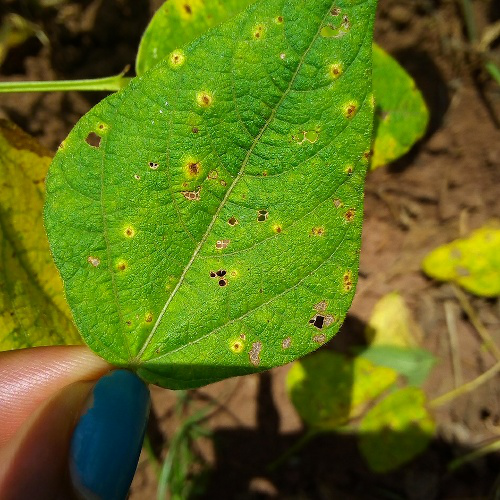

In [ ]:
image = example["image"]
image

Let's learn a little more about the labels in our Dataset. For example, we notice that we have three labels.

In [ ]:
labels = ds["train"].features["labels"]
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

The method `int2str` of one `ClassLabel` allows us to pass the number (integer) representation of the label and reveice the name of the class.

In [ ]:
labels.int2str(example["labels"])

'bean_rust'

### Loading the ViT Feature Extractor

We will prepare these images for our model.

When the ViT models are trained, specific transformations are applied to the images fed to them. If you use the wrong transforms on your image, the model won't understand what it's seeing. 🖼 ➡️

To make sure we apply the correct transformations, we'll use a `ViTFeatureExtractor` initialized with a configuration that was saved along with the pretrained model we plan to use. In our case we used the `google/vit-base-patch16-224-in21k` template, so we loaded its deacture extractor from the Hub.

A feature extractor is responsible for preparing the input features of a model.


In [ ]:
from transformers import ViTFeatureExtractor

repo_id = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(repo_id)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

You can see the extractor configuration by printing it

In [ ]:
print(feature_extractor)

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}



To process an image, simply pass it to the extractor's `call` function. This will return a dictionary containing pixel values, which is the numeric representation that will be passed to the model.

By default we get a NumPy array, but if we add the `return_tensors='pt'` argument, we get PyTorch tensors instead.

In [ ]:
feature_extractor(image, return_tensors="pt")

{'pixel_values': tensor([[[[-0.7961, -0.7333, -0.6627,  ..., -0.8275, -0.8745, -0.8902],
          [-0.8431, -0.7961, -0.7647,  ..., -0.8431, -0.8824, -0.8902],
          [-0.8667, -0.8510, -0.8353,  ..., -0.8510, -0.8745, -0.8824],
          ...,
          [-0.1843, -0.2471, -0.3333,  ..., -0.8353, -0.7490, -0.7098],
          [-0.2392, -0.2941, -0.3725,  ..., -0.8118, -0.7412, -0.7490],
          [-0.2706, -0.3333, -0.3961,  ..., -0.7961, -0.7412, -0.7725]],

         [[-0.8431, -0.8039, -0.7569,  ..., -0.8824, -0.9216, -0.9294],
          [-0.8902, -0.8588, -0.8431,  ..., -0.8980, -0.9216, -0.9294],
          [-0.8980, -0.8902, -0.8824,  ..., -0.8902, -0.9137, -0.9216],
          ...,
          [-0.6314, -0.6706, -0.7098,  ..., -0.8588, -0.7490, -0.7020],
          [-0.6471, -0.6784, -0.7098,  ..., -0.8353, -0.7569, -0.7569],
          [-0.6627, -0.6941, -0.7176,  ..., -0.8196, -0.7647, -0.7882]],

         [[-0.9843, -0.9529, -0.9294,  ..., -0.9686, -0.9765, -0.9765],
          [-0

Returns a dictionary with a single key.

In [ ]:
feature_extractor(image, return_tensors="pt").keys()

dict_keys(['pixel_values'])

Wa can see the shape of the pixel tensor.

In [ ]:
feature_extractor(image, return_tensors="pt")["pixel_values"].shape

torch.Size([1, 3, 224, 224])

### Processing the dataset

Now we can read images and tranform them into inputs for our model. Let's write a function that will put those two steps together. Remember that `feature_extractor` returns a dictionary with the `pixel_values` key. We add a second key with the labels `labels`.

In [ ]:
def process_example(example):
  inputs = feature_extractor(example["image"], return_tensors="pt")
  inputs["labels"] = example["labels"]
  return input

This is what an example looks like processed this way.

In [ ]:
process_example(ds["train"][10])

<bound method Kernel.raw_input of <google.colab._kernel.Kernel object at 0x7f5f218e3250>>

We can call the `map` function and apply this to all the examples at once. But this can be very slow, especially if you use a larger dataset.

We can then apply a ***transformation*** to the dataset. The transformations only apply to the examples as we index them.

However, you will first need to update the latter function to accept a batch with possibly more than one image, as that is what `ds.with_transform` expects.

In [ ]:
def transform(example_batch):
  inputs = feature_extractor([x for x in example_batch["image"]], return_tensors="pt")

  inputs["labels"] = example_batch["labels"]
  return inputs

You can apply this directly to the dataset using `ds.with_transform(transform)`

In [ ]:
prepared_ds = ds.with_transform(transform)

Now every time you get an instance from the dataset, the transformation will be applied in real time.

In [ ]:
prepared_ds["train"][0:2]

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1922, -0.2549],
          [-0.6078, -0.6000, -0.5843,  ..., -0.0353, -0.0196, -0.2706],
          [-0.6314, -0.6314, -0.6157,  ..., -0.2392, -0.3647, -0.2314],
          ...,
          [-0.5373, -0.5529, -0.5765,  ..., -0.0745, -0.0431, -0.0980],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3176,  0.1608,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2784,  0.1451,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3569, -0.3176, -0.5608],
          [-0.7490, -0.7490, -0.7647,  ..., -0.5373, -0.6627, -0.5373],
          ...,
          [-0.7725, -0.7882, -0.8196,  ..., -0.2314, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1843,  0.3176,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0745,  0.2863,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3647, -0.7333],
          [-0

The resulting `pixel_values` tensor ​​will have the form (2, 3, 224, 224) because we pass a batch of two examples.

### Defining the data collator


The data collators, or data recopilators, are objects that form batches using a examples list of our datasets. In order to generate the batches, data collators may apply some processing (such as padding in the examples with text).

We define a function, `collate_fn`, that will act as our data collator. It will return a dictionary for each batch. You will receive a batch of data that will then be processed.

The batches arrive as lists of dicts. Each dict has the `label` and `pixel_values` of their respective examples, so you can just unpack them and stack them into batch tensors. `torch.stack` allows us to concatenate (paste) tensors.


In [ ]:
import torch

def collect_function(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch])
  }

## Training and Evaluation

Let's define the rest of the arguments needed for `Trainer`.

### Defining the metric 

From the `Datasets` library we can also load metrics. `accuracy` can easily be used to compare the predictions with the original labels.

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(prediction):
  return metric.compute(predictions=np.argmax(prediction.predictions, axis=1), references=prediction.label_ids)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  after removing the cwd from sys.path.


### Configuring `Trainer`

Let's load the pretrained model. We will add `num_labels` so that the model creates a classification header with the correct number of labels. We will also include the `id2label` and `label2id` mappings to have human readable labels on the Hub widget.

In [ ]:
from transformers import ViTForImageClassification

labels = ds["train"].features["labels"].names

model = ViTForImageClassification.from_pretrained(
    repo_id,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The last thing needed before that is to set up the training configuration by defining `TrainingArguments`.

Most of these are self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This will remove any functions that don't use the model call function. Defaults to True because it's generally ideal to remove unused function columns, making it easier to unpack the inputs in the model calling function. But, in our case, we need the unused functions ('image' in particular) to create ``pixel_values`'.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="jeraldflowers/vit_model",
    evaluation_strategy="steps",
    num_train_epochs=4,
    learning_rate=2e-4,
    remove_unused_columns=False,
    push_to_hub=True,
    load_best_model_at_end=True
)

Let's pass everything to `Trainer`.

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper

Finally, let's define our `Trainer`.

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collect_function,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor
)

Cloning https://huggingface.co/jeraldflowers/vit_model into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.47k/327M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.30k/3.30k [00:00<?, ?B/s]

Download file runs/Nov27_05-21-44_934771ea7931/1669526524.2720497/events.out.tfevents.1669526524.934771ea7931.…

Download file runs/Nov27_05-21-44_934771ea7931/events.out.tfevents.1669526524.934771ea7931.76.0:  40%|####    …

Clean file training_args.bin:  30%|###       | 1.00k/3.30k [00:00<?, ?B/s]

Download file runs/Nov28_19-07-49_b5afba37e489/1669662664.747274/events.out.tfevents.1669662664.b5afba37e489.7…

Clean file runs/Nov27_05-21-44_934771ea7931/1669526524.2720497/events.out.tfevents.1669526524.934771ea7931.76.…

Download file runs/Nov28_19-07-49_b5afba37e489/events.out.tfevents.1669662664.b5afba37e489.76.0:  77%|#######7…

Clean file runs/Nov27_05-21-44_934771ea7931/events.out.tfevents.1669526524.934771ea7931.76.0:  22%|##2       |…

Clean file runs/Nov28_19-07-49_b5afba37e489/1669662664.747274/events.out.tfevents.1669662664.b5afba37e489.76.1…

Clean file runs/Nov28_19-07-49_b5afba37e489/events.out.tfevents.1669662664.b5afba37e489.76.0:  22%|##2       |…

Clean file pytorch_model.bin:   0%|          | 1.00k/327M [00:00<?, ?B/s]

### Trainig

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1034
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 520
  Number of trainable parameters = 85800963


Step,Training Loss,Validation Loss


### Evaluation

In [ ]:
metrics = trainer.evaluate(prepared_ds["validation"])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

### Let's share in the Hub

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": ["beans"],
    "tags": ["image-classification"]
}

trainer.push_to_hub(commit_message="Task accomplished", **kwargs)